In [27]:
import pandas as pd
import numpy as np

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler 

import matplotlib.pyplot as plt
import seaborn as sns

from ale_utils import first_order_aleplot_quant, second_order_aleplot_quant

In [2]:
df=pd.read_csv("preprocessed.csv", index_col=0)
df.drop("date",axis=1,inplace=True)
df

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,DOW
206668,Air_India,Delhi,Evening,one,Night,Mumbai,Business,24.75,1,42220,4
206669,Air_India,Delhi,Night,one,Night,Mumbai,Business,26.50,1,44450,4
206670,Air_India,Delhi,Evening,one,Night,Mumbai,Business,6.67,1,46690,4
206671,Vistara,Delhi,Evening,zero,Night,Mumbai,Business,2.17,1,50264,4
206672,Air_India,Delhi,Night,one,Afternoon,Mumbai,Business,17.75,1,50669,4
...,...,...,...,...,...,...,...,...,...,...,...
206661,Vistara,Chennai,Early_Morning,one,Night,Hyderabad,Economy,13.83,49,7697,3
206662,Vistara,Chennai,Early_Morning,one,Night,Hyderabad,Economy,13.83,49,7709,3
206663,Vistara,Chennai,Afternoon,one,Morning,Hyderabad,Economy,20.58,49,8640,3
206664,Vistara,Chennai,Morning,one,Morning,Hyderabad,Economy,23.33,49,8640,3


In [5]:
df

,duration,days_left,price,airline_Air_India,airline_Other,airline_Vistara,source_city_Bangalore,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,...,destination_city_Mumbai,class_Business,class_Economy,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6
206668,24.75,1,42220,1,0,0,0,0,1,0,...,1,1,0,0,0,0,0,1,0,0
206669,26.50,1,44450,1,0,0,0,0,1,0,...,1,1,0,0,0,0,0,1,0,0
206670,6.67,1,46690,1,0,0,0,0,1,0,...,1,1,0,0,0,0,0,1,0,0
206671,2.17,1,50264,0,0,1,0,0,1,0,...,1,1,0,0,0,0,0,1,0,0
206672,17.75,1,50669,1,0,0,0,0,1,0,...,1,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206661,13.83,49,7697,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
206662,13.83,49,7709,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
206663,20.58,49,8640,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
206664,23.33,49,8640,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0


## Data Preprocessing
* One Hot Encoding: `['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class', 'DOW']`
* Standardization

In [4]:
df=pd.get_dummies(data=df, columns=['airline', 'source_city', 'departure_time', 'stops', 'arrival_time',
       'destination_city', 'class', 'DOW'])

In [6]:
# standardize predictors
X = df.drop('price',axis=1).values # extract as numpy ndarray
X_mean,X_std = X.mean(axis=0),X.std(axis=0)
X = (X-X_mean)/X_std

# standardize response
y = df['price'].values
y_mean,y_std = y.mean(),y.std()
y = (y-y_mean)/y_std

## Hyperparameter Tuning
* lambda=0.01,0.1,1
* hidden layers sizes=1,5,10

In [10]:
# initial model object
nn_init = MLPRegressor(
    hidden_layer_sizes=10,
    activation='logistic',
    solver='lbfgs',
    alpha=0.01,
    max_iter = 1000
)

In [15]:
# Tune Hyperparameter
np.random.seed(123)

# Folds
n_folds = 5
kf = KFold(n_splits=n_folds,shuffle=True)

# Cross Validation
alphas = [0.01,0.1,1]
sizes = [1,5,10]
nn_tuned = GridSearchCV(
    estimator=nn_init,
    param_grid={ 
        'alpha':alphas,
        'hidden_layer_sizes':sizes,
    },
    scoring='neg_mean_squared_error', # score - negative mse
    refit=True, # whether to fit the model with the best configuration on the entire training set.
    cv=kf,
    return_train_score=True,
    n_jobs=1, 
).fit(X,y)

# Result
print("Tuned parameters:", nn_tuned.best_params_)
print("Test MSE:", -nn_tuned.best_score_)
print("Test R_2:",1-(-nn_tuned.best_score_)/y.var())

Tuned parameters: {'alpha': 0.01, 'hidden_layer_sizes': 10}
Test MSE: 0.02705681944384657
Test R_2: 0.9729431805561535


## Final Model
* Metrics: training MSE, training $R^{2}$

In [49]:
# Standardized training result (on whole dataset)
y_pred = nn_tuned.predict(X)
# residuals (unstandardized)
e = y-y_pred

# training metrics
training_rmse=np.sqrt(np.mean(e**2))
training_r2 = 1 - e.var()/y.var()
print('Training mse:',training_rmse)
print('Training R2:',training_r2)

Training mse: 0.16304856080188074
Training R2: 0.9734151702171908


In [50]:
# Unstandardized training result (on whole dataset)
y_pred = nn_tuned.predict(X)
# residuals (unstandardized)
e = (y*y_std+y_mean)-(y_pred*y_std+y_mean)

# training metrics
training_rmse=np.sqrt(np.mean(e**2))
training_r2 = 1 - e.var()/(y_std**2)
print('Training rmse:',training_rmse)
print('Training R2:',training_r2)

Training rmse: 3662.988426604251
Training R2: 0.9734151702171908


C:\Users\MENG_YUWE\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
C:\Users\MENG_YUWE\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
C:\Users\MENG_YUWE\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
C:\Users\MENG_YUWE\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


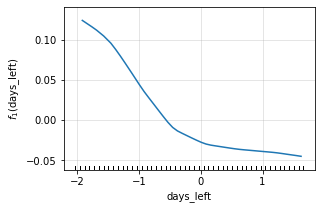

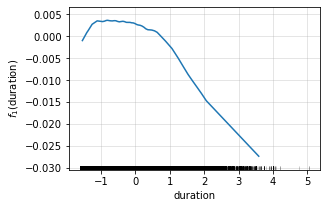

In [24]:
# ALE plot
X_dat = pd.DataFrame(X,columns=df.drop('price',axis=1).columns)

fig,ax = plt.subplots(1,1,figsize=(4.5,3))
# plot the first order ALE effects for feature 'Cement'
ax,ale_cement,_ = first_order_aleplot_quant(
    predictor=nn_tuned.predict, # prediction function
    train_data=X_dat,
    feature='days_left',
    bins=50,ax=ax
)

fig,ax = plt.subplots(1,1,figsize=(4.5,3))
# plot the first order ALE effects for feature 'Cement'
ax,ale_cement,_ = first_order_aleplot_quant(
    predictor=nn_tuned.predict, # prediction function
    train_data=X_dat,
    feature='duration',
    bins=50,ax=ax
)

C:\Users\MENG_YUWE\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
C:\Users\MENG_YUWE\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
C:\Users\MENG_YUWE\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
C:\Users\MENG_YUWE\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


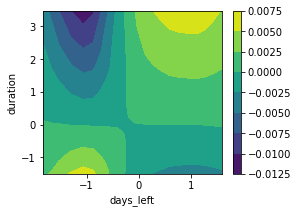

In [26]:
# 2nd order interaction effect
fig,ax = plt.subplots(1,1,figsize=(4,3))
_ = second_order_aleplot_quant(
    predictor=nn_tuned.predict,
    train_data=X_dat,
    features=['days_left','duration'],
    fig=fig,
    ax=ax,
    bins=20,
    mark_empty=True
)